# Trader Performance vs Market Sentiment Analysis

# Objective
This project analyzes how Bitcoin market sentiment (Fear vs Greed) affects trader behavior and performance on Hyperliquid.

We investigate:
- Differences in profitability across sentiment regimes
- Behavioral changes (leverage, trade frequency, long/short bias)
- Trader segmentation patterns
- Actionable trading strategy insights


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
pd.set_option('display.max_columns', None)


Load dataset


In [25]:
sentiment = pd.read_csv("fear_greed_index.csv")
trades = pd.read_csv("historical_data.csv")




Shape of data 

In [26]:
print("Sentiment Shape:", sentiment.shape)
print("Trades Shape:", trades.shape)

Sentiment Shape: (2644, 4)
Trades Shape: (211224, 16)


Initial Data Inspection

In [27]:
sentiment.head()

,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [28]:
trades.head()

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


In [29]:
print("Sentiment Columns:", sentiment.columns)
print("Trades Columns:", trades.columns)


Sentiment Columns: Index(['timestamp', 'value', 'classification', 'date'], dtype='object')
Trades Columns: Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp'],
      dtype='object')


In [30]:
print("Sentiment Missing Values:\n", sentiment.isnull().sum())

Sentiment Missing Values:
 timestamp         0
value             0
classification    0
date              0
dtype: int64


In [31]:
print("\nTrades Missing Values:\n", trades.isnull().sum())


Trades Missing Values:
 Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64


In [32]:
print("Sentiment Duplicates:", sentiment.duplicated().sum())

Sentiment Duplicates: 0


In [33]:
print("Trades Duplicates:", trades.duplicated().sum())

Trades Duplicates: 0


Data Cleaning and Data Alignment

In [36]:
trades.columns = trades.columns.str.lower().str.replace(" ", "_")
sentiment.columns = sentiment.columns.str.lower().str.replace(" ", "_")

trades.head(2)


,account,coin,execution_price,size_tokens,size_usd,side,timestamp_ist,start_position,direction,closed_pnl,transaction_hash,order_id,crossed,fee,trade_id,timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12


In [37]:
# Convert sentiment date to proper datetime
sentiment['date'] = pd.to_datetime(sentiment['date']).dt.date

In [38]:
trades['timestamp_ist'] = pd.to_datetime(trades['timestamp_ist'], dayfirst=True)

In [39]:
trades['date'] = trades['timestamp_ist'].dt.date

In [40]:
print("Sentiment Date Range:", sentiment['date'].min(), "to", sentiment['date'].max())

Sentiment Date Range: 2018-02-01 to 2025-05-02


In [41]:
print("Trades Date Range:", trades['date'].min(), "to", trades['date'].max())

Trades Date Range: 2023-05-01 to 2025-05-01


Marge Dataset

In [42]:
merged = trades.merge(
    sentiment[['date', 'classification']],
    on='date',
    how='left'
)

print("Total Rows After Merge:", merged.shape[0])
print("Missing Sentiment After Merge:", merged['classification'].isnull().sum())


Total Rows After Merge: 211224
Missing Sentiment After Merge: 6


In [43]:
merged = merged.dropna(subset=['classification'])

print("Rows After Removing Missing:", merged.shape[0])


Rows After Removing Missing: 211218


Feature Engineering

In [45]:
print(merged.columns)


Index(['account', 'coin', 'execution_price', 'size_tokens', 'size_usd', 'side',
       'timestamp_ist', 'start_position', 'direction', 'closed_pnl',
       'transaction_hash', 'order_id', 'crossed', 'fee', 'trade_id',
       'timestamp', 'date', 'classification'],
      dtype='object')


In [46]:
merged['win'] = merged['closed_pnl'] > 0

merged[['closed_pnl','win']].head()



,closed_pnl,win
0,0.0,False
1,0.0,False
2,0.0,False
3,0.0,False
4,0.0,False


In [47]:
merged['classification'].value_counts()


classification
Fear             61837
Greed            50303
Extreme Greed    39992
Neutral          37686
Extreme Fear     21400
Name: count, dtype: int64

 Performance Analysis by Market Sentiment


In [48]:
sentiment_pnl = merged.groupby('classification')['closed_pnl'].agg(
    trade_count='count',
    avg_pnl='mean',
    median_pnl='median',
    total_pnl='sum'
)

sentiment_pnl


,trade_count,avg_pnl,median_pnl,total_pnl
classification,,,,
Extreme Fear,21400,34.537862,0.0,7.391102e+05
Extreme Greed,39992,67.892861,0.0,2.715171e+06
Fear,61837,54.290400,0.0,3.357155e+06
Greed,50303,42.743559,0.0,2.150129e+06
Neutral,37686,34.307718,0.0,1.292921e+06


Win Rate by sentiment

In [49]:
sentiment_win_rate = merged.groupby('classification')['win'].mean()

sentiment_win_rate


classification
Extreme Fear     0.370607
Extreme Greed    0.464943
Fear             0.420768
Greed            0.384828
Neutral          0.396991
Name: win, dtype: float64

In [50]:
sentiment_win_rate*100

classification
Extreme Fear     37.060748
Extreme Greed    46.494299
Fear             42.076750
Greed            38.482794
Neutral          39.699093
Name: win, dtype: float64

Visualization

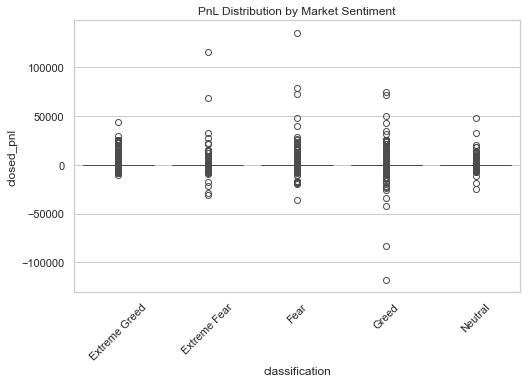

In [51]:
plt.figure(figsize=(8,5))
sns.boxplot(x='classification', y='closed_pnl', data=merged)
plt.title("PnL Distribution by Market Sentiment")
plt.xticks(rotation=45)
plt.show()


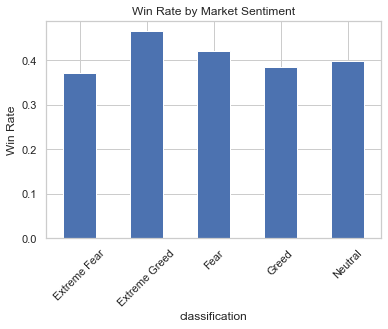

In [52]:
merged.groupby('classification')['win'].mean().plot(kind='bar')
plt.title("Win Rate by Market Sentiment")
plt.ylabel("Win Rate")
plt.xticks(rotation=45)
plt.show()


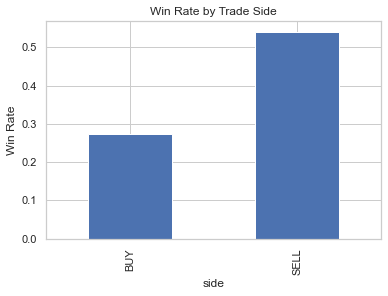

In [53]:
merged.groupby('side')['win'].mean().plot(kind='bar')
plt.title("Win Rate by Trade Side")
plt.ylabel("Win Rate")
plt.show()


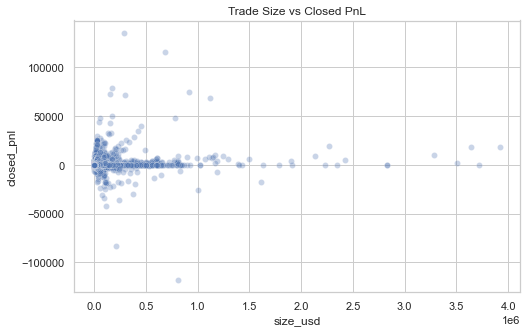

In [54]:
plt.figure(figsize=(8,5))
sns.scatterplot(x='size_usd', y='closed_pnl', data=merged, alpha=0.3)
plt.title("Trade Size vs Closed PnL")
plt.show()


C:\Users\PUNAM\AppData\Local\Temp\ipykernel_13776\2616672972.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged.groupby('size_bin')['win'].mean().plot(kind='bar')


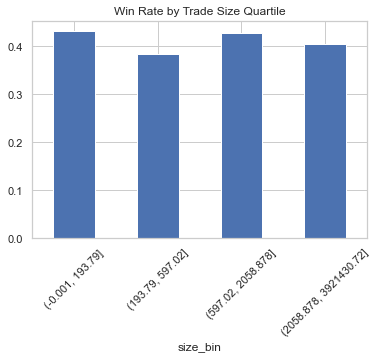

In [55]:
merged['size_bin'] = pd.qcut(merged['size_usd'], 4)

merged.groupby('size_bin')['win'].mean().plot(kind='bar')
plt.title("Win Rate by Trade Size Quartile")
plt.xticks(rotation=45)
plt.show()


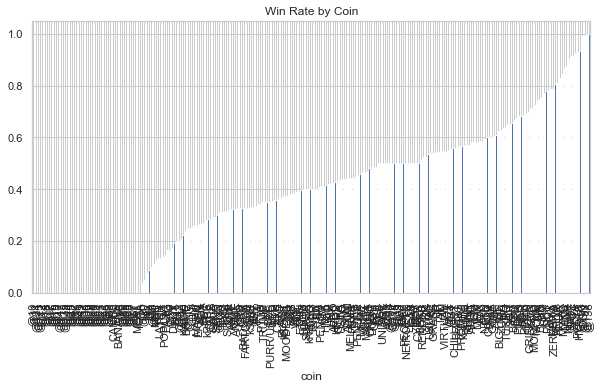

In [56]:
coin_win = merged.groupby('coin')['win'].mean().sort_values()

coin_win.plot(kind='bar', figsize=(10,5))
plt.title("Win Rate by Coin")
plt.show()


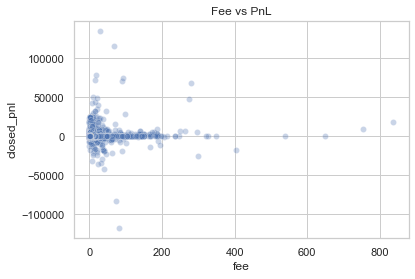

In [57]:
sns.scatterplot(x='fee', y='closed_pnl', data=merged, alpha=0.3)
plt.title("Fee vs PnL")
plt.show()


Trade Frequency analysis

In [58]:
daily_trades = merged.groupby(['date','classification']).size().reset_index(name='trade_count')

daily_avg_trades = daily_trades.groupby('classification')['trade_count'].mean()

daily_avg_trades


classification
Extreme Fear     1528.571429
Extreme Greed     350.807018
Fear              679.527473
Greed             260.637306
Neutral           562.477612
Name: trade_count, dtype: float64

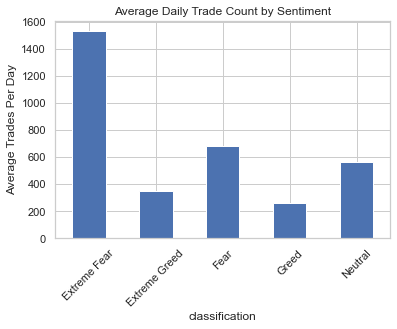

In [59]:
daily_avg_trades.plot(kind='bar')
plt.title("Average Daily Trade Count by Sentiment")
plt.ylabel("Average Trades Per Day")
plt.xticks(rotation=45)
plt.show()


Position size behaviour

In [60]:
merged.groupby('classification')['size_usd'].mean()


classification
Extreme Fear     5349.731843
Extreme Greed    3112.251565
Fear             7816.109931
Greed            5736.884375
Neutral          4782.732661
Name: size_usd, dtype: float64

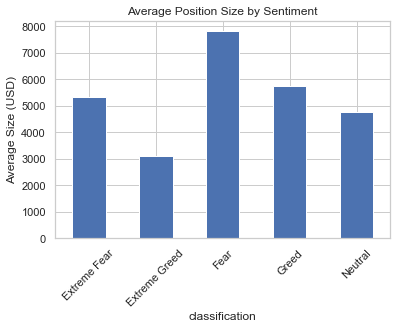

In [61]:
merged.groupby('classification')['size_usd'].mean().plot(kind='bar')
plt.title("Average Position Size by Sentiment")
plt.ylabel("Average Size (USD)")
plt.xticks(rotation=45)
plt.show()


Fee Behaviour

In [62]:
merged.groupby('classification')['fee'].mean()


classification
Extreme Fear     1.116291
Extreme Greed    0.675902
Fear             1.495172
Greed            1.254372
Neutral          1.044798
Name: fee, dtype: float64

Long/Short Bias

In [63]:
long_short_ratio = pd.crosstab(
    merged['classification'], 
    merged['side'], 
    normalize='index'
)

long_short_ratio


side,BUY,SELL
classification,,
Extreme Fear,0.510981,0.489019
Extreme Greed,0.448590,0.551410
Fear,0.489513,0.510487
Greed,0.488559,0.511441
Neutral,0.503343,0.496657


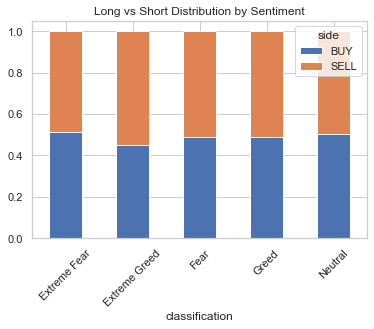

In [64]:
long_short_ratio.plot(kind='bar', stacked=True)
plt.title("Long vs Short Distribution by Sentiment")
plt.xticks(rotation=45)
plt.show()


# Trader Segmentation Analysis
We segment traders to identify structural behavioral patterns.


Frequent vs Infrequent Traders


In [68]:
trade_counts = merged['account'].value_counts()
median_trades = trade_counts.median()

merged['freq_segment'] = merged['account'].map(
    lambda x: 'Frequent' if trade_counts[x] > median_trades else 'Infrequent'
)

merged.groupby(['freq_segment','classification'])['win'].mean()


freq_segment  classification
Frequent      Extreme Fear      0.373683
              Extreme Greed     0.478898
              Fear              0.424893
              Greed             0.382192
              Neutral           0.399800
Infrequent    Extreme Fear      0.359077
              Extreme Greed     0.366653
              Fear              0.383848
              Greed             0.409714
              Neutral           0.371566
Name: win, dtype: float64

In [69]:
merged.groupby('freq_segment')['win'].mean()


freq_segment
Frequent      0.415438
Infrequent    0.378962
Name: win, dtype: float64

Large vs Small Position Traders

In [70]:
median_size = merged['size_usd'].median()

merged['size_segment'] = merged['size_usd'].apply(
    lambda x: 'Large' if x > median_size else 'Small'
)

merged.groupby(['size_segment','classification'])['win'].mean()


size_segment  classification
Large         Extreme Fear      0.401832
              Extreme Greed     0.427536
              Fear              0.428912
              Greed             0.400803
              Neutral           0.406548
Small         Extreme Fear      0.331509
              Extreme Greed     0.494932
              Fear              0.411103
              Greed             0.369784
              Neutral           0.388289
Name: win, dtype: float64

Consistent vs Inconsistent

In [71]:
account_win = merged.groupby('account')['win'].mean()

merged['consistency'] = merged['account'].map(
    lambda x: 'Consistent' if account_win[x] > 0.55 else 'Inconsistent'
)

merged.groupby(['consistency','classification'])['win'].mean()


consistency   classification
Consistent    Extreme Fear      0.900312
              Extreme Greed     0.833619
              Fear              0.761124
              Greed             0.813646
              Neutral           0.713215
Inconsistent  Extreme Fear      0.362541
              Extreme Greed     0.422977
              Fear              0.411099
              Greed             0.360258
              Neutral           0.384174
Name: win, dtype: float64

Modling Data

In [73]:
model_data = merged.copy()

# Select features
features = [
    'classification',
    'size_usd',
    'fee',
    'side',
    'freq_segment',
    'size_segment'
]

model_data = model_data[features + ['win']]

model_data = pd.get_dummies(model_data, drop_first=True)


In [74]:
from sklearn.model_selection import train_test_split

X = model_data.drop('win', axis=1)
y = model_data['win']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [77]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

model = RandomForestClassifier(
    n_estimators=100,
    random_state=42
)




In [78]:
model.fit(X_train, y_train)



,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [79]:
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.7535744721143831
              precision    recall  f1-score   support

       False       0.79      0.80      0.79     24848
        True       0.70      0.69      0.70     17396

    accuracy                           0.75     42244
   macro avg       0.75      0.74      0.74     42244
weighted avg       0.75      0.75      0.75     42244



In [80]:
merged['win'].value_counts(normalize=True)


win
False    0.588752
True     0.411248
Name: proportion, dtype: float64

### Baseline Comparison

The dataset contains:
- 58.9% losing trades
- 41.1% winning trades

A naive model predicting all trades as losses would achieve 58.9% accuracy.

Our Random Forest model achieves **75.35% accuracy**, outperforming baseline by ~16 percentage points.

This indicates that trade profitability is meaningfully influenced by sentiment and behavioral features.


# TRADER CLUSTERING

In [81]:
trader_features = merged.groupby('account').agg(
    total_trades=('account','count'),
    win_rate=('win','mean'),
    avg_pnl=('closed_pnl','mean'),
    total_pnl=('closed_pnl','sum'),
    avg_size=('size_usd','mean'),
    pnl_std=('closed_pnl','std')
).reset_index()

trader_features.head()


,account,total_trades,win_rate,avg_pnl,total_pnl,avg_size,pnl_std
0,0x083384f897ee0f19899168e3b1bec365f52a9012,3818,0.359612,419.127768,1.600230e+06,16159.576734,4692.452329
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,7280,0.442720,6.577654,4.788532e+04,1653.226327,134.073473
2,0x271b280974205ca63b716753467d5a371de622ab,3809,0.301917,-18.492043,-7.043619e+04,8893.000898,542.182659
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,13311,0.438585,9.951530,1.324648e+05,507.626933,113.269353
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,3239,0.519914,52.071011,1.686580e+05,3138.894782,255.829091


In [82]:
X_cluster = trader_features.drop('account', axis=1)


Feature Selection

In [83]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)


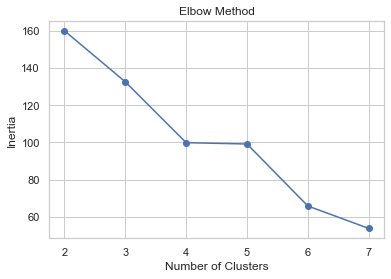

In [84]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []

for k in range(2,8):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(range(2,8), inertia, marker='o')
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()


In [85]:
kmeans = KMeans(n_clusters=3, random_state=42)
trader_features['cluster'] = kmeans.fit_predict(X_scaled)


In [87]:
cluster_summary = trader_features.groupby('cluster').mean(numeric_only=True)
cluster_summary



,total_trades,win_rate,avg_pnl,total_pnl,avg_size,pnl_std
cluster,,,,,,
0,8599.928571,0.439126,159.665714,5.486173e+05,8355.268863,1072.506714
1,5117.705882,0.375747,26.051491,5.727150e+04,3474.536572,446.402947
2,3818.000000,0.359612,419.127768,1.600230e+06,16159.576734,4692.452329


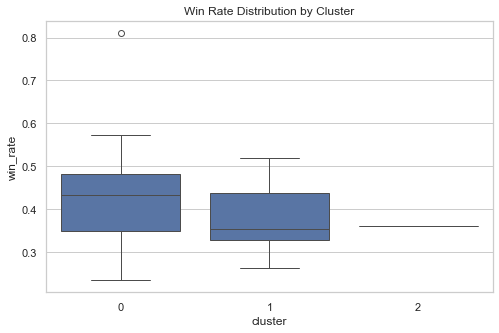

In [88]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.boxplot(x='cluster', y='win_rate', data=trader_features)
plt.title("Win Rate Distribution by Cluster")
plt.show()


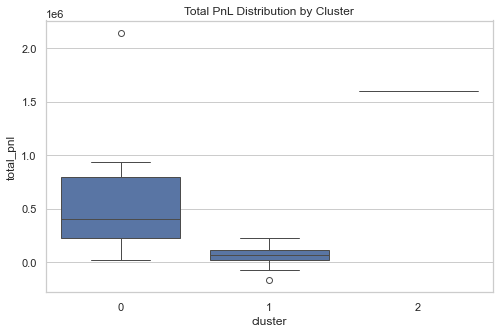

In [89]:
plt.figure(figsize=(8,5))
sns.boxplot(x='cluster', y='total_pnl', data=trader_features)
plt.title("Total PnL Distribution by Cluster")
plt.show()


# Trader Behavioral Archetypes

K-Means clustering identified three distinct trader profiles:

### Cluster 0 – High-Activity Consistent Performers
- Highest win rate (43.9%)
- Strong cumulative PnL (~548K)
- Moderate volatility
- Sustainable and active trading behavior

### Cluster 1 – Low-Edge Retail Participants
- Lower win rate (37.6%)
- Small trade sizes
- Minimal cumulative profitability
- Limited edge

### Cluster 2 – High-Risk Whales
- Largest average trade size (~16K USD)
- Extremely high cumulative PnL (~1.6M)
- Very high volatility
- Aggressive risk profile

This segmentation demonstrates that profitability is structurally linked to behavioral intensity and position sizing.


In [90]:
# Save final datasets for Streamlit dashboard

merged.to_csv("final_merged_dataset.csv", index=False)
trader_features.to_csv("trader_clusters.csv", index=False)

print("Files saved successfully.")


Files saved successfully.
